In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import scipy.stats.mstats as ssm                    
from scipy.stats import gaussian_kde as kde
import random
import seaborn as sns                              
import sklearn.ensemble as forest
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.learning_curve import learning_curve
from sklearn.cluster import KMeans



## Preprocessing: Data Cleaning, feature selection, dummy encoding

In [2]:
data = pd.read_csv("CrowdstormingDataJuly1st.csv")

#Delete non-significants features.
data = data.drop(['birthday', 'player', 'Alpha_3', 'photoID'], axis=1)

In [3]:
nb_values = len(data)

print(len(data.dropna())/len(data))

0.790649738406333


#### We can see that when we drop all the row where we have at least one NaN value, we still have 79.1% of the data remaining. We checked that by removing only rows containing missing values in the set {position AND (rater1 OR rater2) } we obtain 79.5% so we finaly came up with the easiest way as the improvement were not significants

In [4]:
# drop all the rows with a NaN value
data = data.dropna()



####  Now that we loaded our dataFrame we need to aggregate the value of different features for each player as for example the number of yellow/red cars obtained

#### First, we need to encode some features as club, leagueCountry and position 

In [5]:
# function that encode
encode = preprocessing.LabelEncoder()

# encode the position columns values
encode.fit(data['club'])
club_encoded = encode.transform(data['club'])

# encode the leagueCountry columns values
encode.fit(data['leagueCountry'])
league_encoded = encode.transform(data['leagueCountry'])

# encode the position columns values
encode.fit(data['position'])
position_encoded = encode.transform(data['position'])



#### We now create a new DataFrame with thoses encoded features


#### As we have the choice to chose a binary or multiclassification, we came up with a binary classification because multiclassification results were bad. We first tried a 8-label classification {0,0.125,0.25,0.375....,1} and we obtained about 33% accuracy then a 4-label classification {0,0.25,0.5,0.75,1} and obtained about 50% accuracy.

In [7]:
# start by copying the initial data
encoded_df = data.copy()

# replaces the columns string values by integer encoded ones
encoded_df['club'] = club_encoded
encoded_df['leagueCountry'] = league_encoded
encoded_df['position'] = position_encoded

encoded_df = encoded_df.sort_values('playerShort')
encoded_df = encoded_df.reset_index()


#We merge rater1 and rater2 in a single feature skinC 

#reduce the pb to a binary classification 
def BW(x):
    #reduce the label of the target to 2: Black or White.
    if x>0.5:
        x=1
    else :
        x=0
    return x
    
encoded_df['SkinC'] = encoded_df[['rater1','rater2']].mean(axis=1).apply(BW)

#Drop unused features
del encoded_df['index']
del encoded_df['rater1']
del encoded_df['rater2']



In [8]:
encoded_df.head()

,playerShort,club,leagueCountry,height,weight,position,games,victories,ties,defeats,...,redCards,refNum,refCountry,meanIAT,nIAT,seIAT,meanExp,nExp,seExp,SkinC
0,aaron-hughes,33,0,182.0,71.0,1,2,0,0,2,...,0,1333,64,0.352920,5952.0,0.000070,0.445679,6121.0,0.000269,0
1,aaron-hughes,33,0,182.0,71.0,1,1,0,0,1,...,0,2369,40,0.340205,5223.0,0.000081,0.626401,5621.0,0.000373,0
2,aaron-hughes,33,0,182.0,71.0,1,1,0,0,1,...,0,2542,44,0.326690,44791.0,0.000010,0.356446,46916.0,0.000037,0
3,aaron-hughes,33,0,182.0,71.0,1,2,0,1,1,...,0,3099,8,0.336628,7749.0,0.000055,0.335967,7974.0,0.000225,0
4,aaron-hughes,33,0,182.0,71.0,1,16,3,5,8,...,0,194,44,0.326690,44791.0,0.000010,0.356446,46916.0,0.000037,0


#### We then aggregated the players. We dropped the features that cant be aggregated, i.e refnum, refcountry, nIAE, nEXP and playershort and chose to also drop seIAE and seEXP as it did not decreased our predictions

In [9]:
aggregated_df=encoded_df[['playerShort','club','leagueCountry','height', 'weight','position','games','victories','ties','defeats', 'goals', 'yellowCards',
       'yellowReds', 'redCards','meanIAT','meanExp','SkinC']].groupby('playerShort').mean()
aggregated_df = aggregated_df.reset_index()
del aggregated_df['playerShort']

In [10]:
aggregated_df.head()

,club,leagueCountry,height,weight,position,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,meanIAT,meanExp,SkinC
0,33.0,0.0,182.0,71.0,1.0,3.939759,1.487952,1.078313,1.373494,0.054217,0.114458,0.000000,0.000000,0.346459,0.494575,0.0
1,86.0,2.0,183.0,73.0,0.0,3.393939,1.424242,0.737374,1.232323,0.626263,0.424242,0.000000,0.010101,0.348818,0.449220,0.0
2,79.0,0.0,165.0,63.0,10.0,4.079208,1.980198,0.960396,1.138614,0.306931,0.108911,0.000000,0.000000,0.345893,0.491482,0.0
3,6.0,0.0,178.0,76.0,3.0,2.500000,1.442308,0.403846,0.653846,0.375000,0.298077,0.000000,0.009615,0.346821,0.514693,0.0
4,48.0,1.0,180.0,73.0,1.0,3.351351,1.108108,1.081081,1.162162,0.027027,0.216216,0.108108,0.054054,0.331600,0.335587,0.0


#### We then split our dataframe into Features/Target 

#### Let's first see which features are the most important for our random tree classifier

In [81]:
entry_df = aggregated_df.ix[:, :15]

# features matrix
X = entry_df.as_matrix()

# because when we are passing label (y) data to  rf.fit(X,y), it expects y to be 1D list.
y = np.asarray(aggregated_df['SkinC'],dtype='str')

## 1 - Supervised Learning Techniques: 

### - Random Forrest Classifier default and tunned

### - Cross validation and Bias-Variance Trade-off

####  One of the benefits of decision trees is that ordinal (continuous or discrete) input data does not require any significant preprocessing. In fact, the results should be consistent regardless of any scaling or translational normalization, since the trees can choose equivalent splitting points. Hence, the only preprocessing property for decision trees is that it doesn't change the relative order of values within each data dimension. We will consequently not preprocess our datas

In [69]:
from sklearn.cross_validation import cross_val_score

model = RandomForestClassifier()
scores = cross_val_score(model, X, y, cv=15)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


Accuracy: 0.84 (+/- 0.04)


In [72]:
# we can see later that this model have a better bias-variance tradeoff even if the accuracy doesnt improve
modeltunned = RandomForestClassifier(max_depth=6, max_features=7)
scorestunned = cross_val_score(modeltunned, X, y, cv=15)
print("Accuracy: %0.2f (+/- %0.2f)" % (scorestunned.mean(), scorestunned.std() * 2))

Accuracy: 0.85 (+/- 0.03)


#### We hence have 85% of accuracy by tuning the parameters of the RF.

#### Let's now focus on dimensionality reduction by seeing which features are significants for the RF model

Feature ranking:
1. feature 13 : meanIAT (0.174130)
2. feature 14 : meanExp (0.172176)
3. feature 1 : leagueCountry (0.112283)
4. feature 6 : victories (0.079268)
5. feature 0 : club (0.058577)
6. feature 7 : ties (0.058029)
7. feature 9 : goals (0.057226)
8. feature 8 : defeats (0.052178)
9. feature 5 : games (0.050256)
10. feature 10 : yellowCards (0.039176)
11. feature 3 : weight (0.039049)
12. feature 11 : yellowReds (0.036291)
13. feature 12 : redCards (0.026378)
14. feature 2 : height (0.025190)
15. feature 4 : position (0.019791)


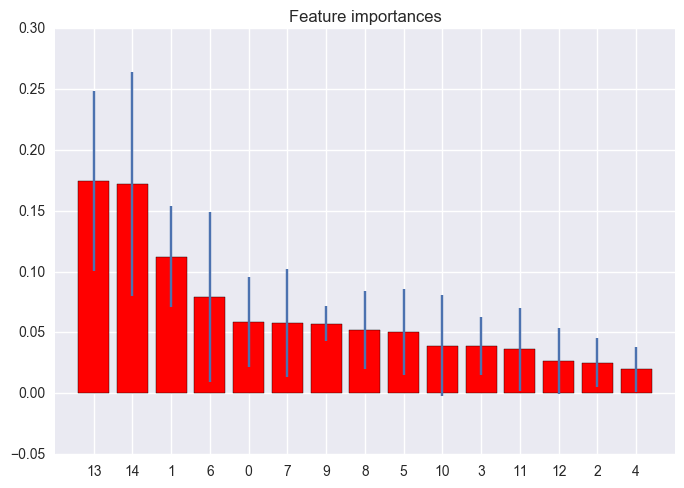

In [32]:
# Build a forest and compute the feature importances
forest = RandomForestClassifier(max_depth = 6, max_features = 7)

forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")


for f in range(X.shape[1]):
    print("%d. feature %d : %s (%f)" % (f + 1, indices[f], aggregated_df.columns[indices[f]] , importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

#### It seems that mean explicit bias and mean implicit bias are  more relevant than the remaining features. Similarly, mean explicit bias, league country and mean implicit bias and victories represent more than 50% of the model so we could expect a slight accuracy decrease by removing them.

#### Indeed our accuracy decrease without mean explicit bias and mean implicit bias

In [74]:
Xtest = np.delete(X,(1,13,14), axis=1)
scores1 = cross_val_score(modeltunned, Xtest, y, cv=15)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores1.mean(), scores1.std() * 2))

Accuracy: 0.84 (+/- 0.02)


#### But slightly increase by removing the less important feature : the position

In [37]:
Xtest2 = np.delete(X,(4),axis=1)
scores2 = cross_val_score(modeltunned,Xtest2,y,cv=15)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores2.mean(), scores2.std() * 2))


Accuracy: 0.85 (+/- 0.03)


#### Learning curves and Bias Variance Tradeoff

#### Focusing on the right side of the plot where there are enough data for evaluation, we can see that when using the default RFC, we suffer from an over fitting problem (High Variance-Low bias) because of the large gap between the two curves and the low training error.

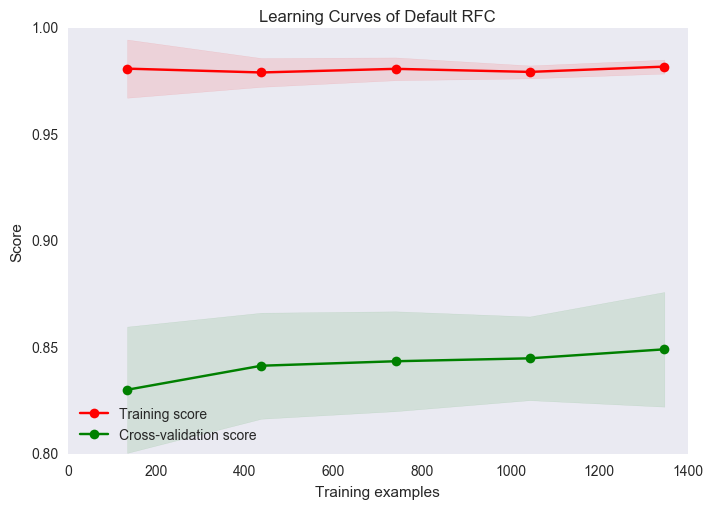

In [33]:
def plot_learning_curve(title, estimator, X, y, cv = 20):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    title : string
        Title for the chart.
        
    estimator: clf

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
    """
    plt.figure()
    plt.title(title)

    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


title = "Learning Curves of Default RFC"

estimator = RandomForestClassifier(n_estimators=10)


plot_learning_curve(title, estimator, X, y)

plt.show()


#### More trees is always better with diminishing returns. Deeper trees are almost always better subject to requiring more trees for similar performance.

#### The above two points are directly a result of the bias-variance tradeoff. Deeper trees reduces the bias; more trees reduces the variance.

#### The most important hyper-parameter is how many features to test for each split. The more useless features there are, the more features we should try. This needs tuned.

#### If we want to increase the bias we can simply make the RF flat. Similarly, to decrease the bias we make the RF deeper

#### It can be shown by the learning curves below


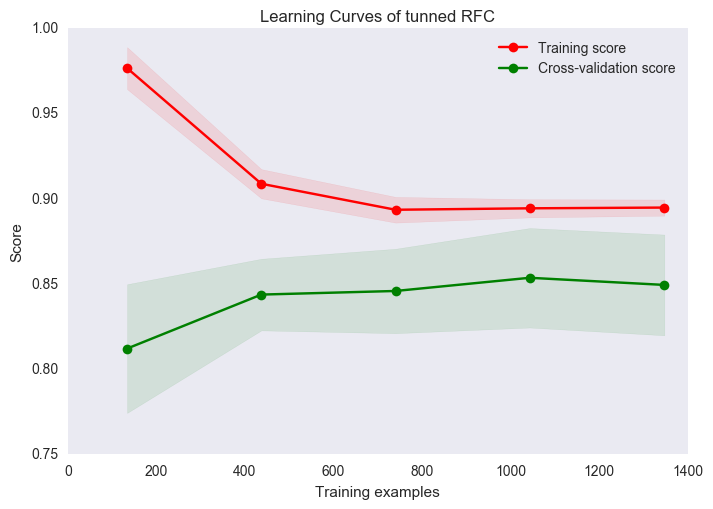

In [34]:

title = "Learning Curves of tunned RFC"

estimator = RandomForestClassifier(max_depth=6, max_features=7)


plot_learning_curve(title, estimator, X, y)

plt.show()

#### We can see that our tunned model has a relatively good bias-variance balance.

## Unsupervised Learning and Clustering:
   
## -Kmeans++
## -DBSCAN

#### When used to transform data, PCA can reduce the dimensionality of the data by projecting on a principal subspace.


In [76]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

kmeans= KMeans(n_clusters=2, init='k-means++').fit(X)
labels = kmeans.labels_
silhouette = silhouette_score(X, labels)
print("silhoute score : " + str(silhouette))

silhoute score : 0.51975167656


Here the silhouette score describe how well each object lies within its cluster. as the silhouette score lies in [-1,1], the given score is not bad.
Let's see for our tunned data with the computed silhouette score the percentage of dark skin colors in the two clusters

In [48]:
first_cluster = y[labels==0].astype(np.float)
second_cluster = y[labels==1].astype(np.float)

In [49]:
# to get the rate of dark_skin players in the first cluster
dark_first_cluster = first_cluster[first_cluster == 1.0]
dark_rate_first = len(dark_first_cluster)/len(first_cluster)
print("rate of dark skin players in the first cluster : " + str(dark_rate_first))

# to get the rate of dark_skin players in the second cluster
dark_second_cluster = second_cluster[second_cluster == 1.0]
dark_rate_second = len(dark_second_cluster)/len(second_cluster)
print("rate of  dark skin players  in the second cluster : " + str(dark_rate_second))

rate of dark skin players in the first cluster : 0.2009132420091324
rate of  dark skin players  in the second cluster : 0.12467191601049869


we can see that we nearly have twice as more dark skin players in the first than the second cluster which is a good result. Let's see if we can get a bigger rate difference by removing some features.

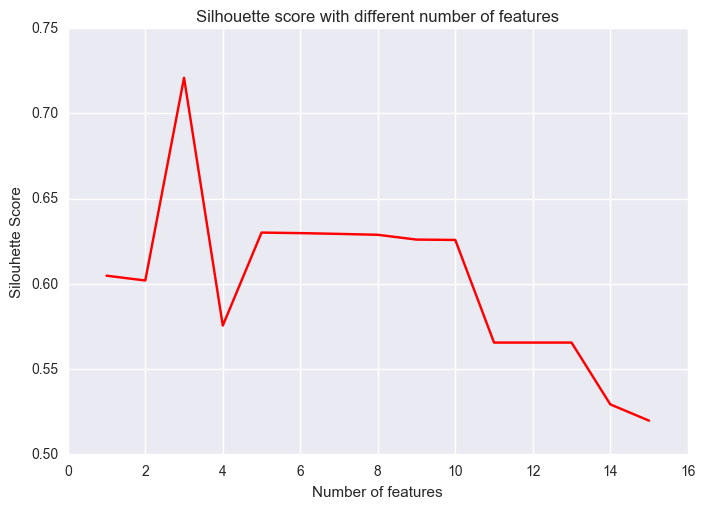

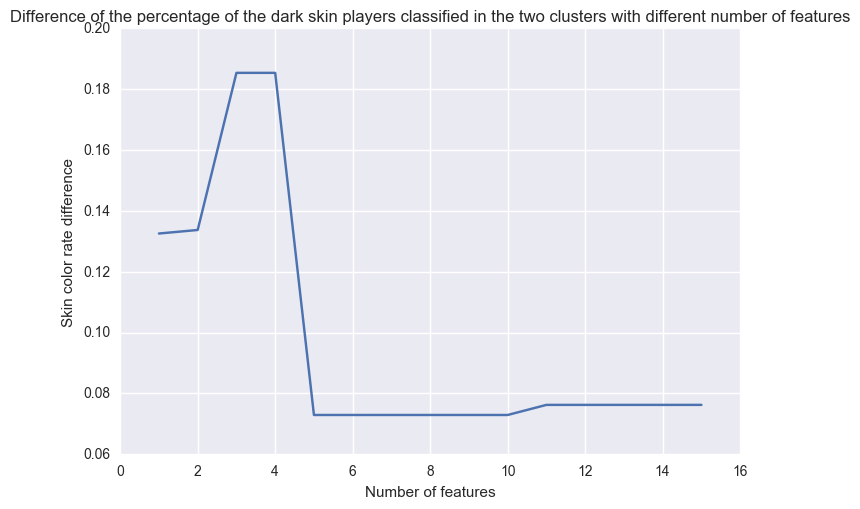

In [117]:
# reorder our matrix with important features first
X_ordered = X[:, indices]

# intialize the arrays for the silhouette scores and the dark rates and their differences
silhouettes = []
rate_dark_difference = []
rates_first = []
rates_second = []

# Loop on features
for nb_feat in range(X.shape[1]):

    # keep the first nb_feat features
    X_ = X_ordered[:, :nb_feat+1].copy()
    kmeans = KMeans(n_clusters=2, init = 'k-means++').fit(X_)
    labels = kmeans.labels_
    silhouettes.append(silhouette_score(X_, labels))
    
    
    # get our two clusters
    first_cluster = y[labels == 0].astype(np.float)
    second_cluster = y[labels == 1].astype(np.float)
    
    # get the rate difference of dark skin players between our two clusters
    dark_first_cluster = first_cluster[first_cluster == 1.0]
    dark_second_cluster = second_cluster[second_cluster == 1.0]
    dark_rate_first = len(dark_first_cluster)/len(first_cluster)
    dark_rate_second = len(dark_second_cluster)/len(second_cluster)
    
    rates_first.append(dark_rate_first)
    rates_second.append(dark_rate_second)
    rate_dark_difference.append(np.abs(dark_rate_second - dark_rate_first))
    

# plot the silhouette score with different number of features
x = range(1,len(silhouettes)+1)
plt.plot(x  , silhouettes, 'r', label = "Silhouette score")
plt.xlabel("Number of features")
plt.ylabel("Silouhette Score")
plt.title('Silhouette score with different number of features')
plt.show()

            
# plot the dark skin player rate color differences in the two clusters
plt.plot(x , rate_dark_difference)
plt.xlabel("Number of features")
plt.ylabel("Skin color rate difference")
plt.title('Difference of the percentage of the dark skin players classified in the two clusters with different number of features')
                                
plt.show()

As it may seems surprising we can see from the two plots that it is best to just use the three most important features (meanIAT, meanExp and theleague country). So having few features improve by far our clustering. 
With the chosen three most important features we get the following values :

In [124]:
print("Silhouette Score : %0f" % silhouettes[2])
print("rate of  dark skin players  in the first cluster : %0f" % rates_first[2])
print("rate of  dark skin players  in the second cluster : %0f" % rates_second[2])

Silhouette Score : 0.720851
rate of  dark skin players  in the first cluster : 0.087760
rate of  dark skin players  in the second cluster : 0.273056


The sihouette score is really good, meaning that our clusters are very well separated with the skin color (3 times more dark skin player in the second than in the first cluster). 